In [1]:
import os, re, sys
import numpy as np
import pandas as pd
from math import log
import random
import scipy.io
import csv

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import tensorflow as tf

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
num_threads = 16
# Maximum number of threads to use for OpenMP parallel regions.
os.environ["OMP_NUM_THREADS"] = "4"
# Without setting below 2 environment variables, it didn't work for me. Thanks to @cjw85 
os.environ["TF_NUM_INTRAOP_THREADS"] = "4"
os.environ["TF_NUM_INTEROP_THREADS"] = "4"

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)
tf.config.set_soft_device_placement(True)

In [6]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6400)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [9]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.regularizers import (
    l2, 
    l1, 
    l1_l2
)
from tensorflow.keras import backend as K
from tensorflow.keras import (
    activations, 
    initializers, 
    regularizers, 
    constraints
)

In [10]:
#import from python files
from model import build_model

In [11]:
# in a well-defined initial state.
random.seed
np.random.seed(1337)
tf.random.set_seed(1337)

In [12]:
import matplotlib
import matplotlib.pyplot as plt

In [13]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint, 
    EarlyStopping
)
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)

In [14]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample, shuffle
from sklearn.feature_selection import (
    SelectKBest,
    chi2
)
#import keras_tuner as kt
from collections import defaultdict

In [ ]:
#import pickle
#with open ('fulldata_pseudoseq_dictionary.pkl', 'rb') as f:
#    pseudo_seq = pickle.load(f)

In [ ]:
import pickle
with open ('fulldata_pseudoseq_dictionary_converted.pkl', 'rb') as f:
    pseudo_seq = pickle.load(f)

In [ ]:
type(pseudo_seq)

In [ ]:
    training_data = []
    for allele in pseudo_seq.keys():
        allele_data = pseudo_seq[allele]
        random.shuffle(allele_data)
        allele_data = np.array(allele_data)
        training_data.extend(allele_data)
    
    [all_pep, all_mhc, all_target] = [[i[j] for i in training_data] for j in range(3)]
    all_pep = np.array(all_pep)
    all_mhc = np.array(all_mhc)
    all_target = np.array(all_target)

In [ ]:
print(all_pep.shape)
print(all_mhc.shape)
print(all_target.shape)

In [ ]:
#np.save('/home/jjia1/jjia1/viralepitope/all_pep.npy', all_pep)
#np.save('/home/jjia1/jjia1/viralepitope/all_mhc.npy', all_mhc)
#np.save('/home/jjia1/jjia1/viralepitope/all_target.npy', all_target)

In [ ]:
np.save('/home/jjia1/jjia1/viralepitope/all_pep_converted.npy', all_pep)
np.save('/home/jjia1/jjia1/viralepitope/all_mhc_converted.npy', all_mhc)
np.save('/home/jjia1/jjia1/viralepitope/all_target_converted.npy', all_target)

In [15]:
all_pep, all_mhc, all_target = np.load('all_pep.npy'), np.load('all_mhc.npy'), np.load('all_target.npy')

In [15]:
all_pep = all_pep.astype(dtype = np.float32)
all_mhc = all_mhc.astype(dtype = np.float32)
all_target = all_target.astype(dtype = np.float32)

In [ ]:
#build 2 models
#one model for the sequence, one model for the MHC names
#integrate the outputs in a final dense layer

In [16]:
def create_model(training_pep, training_mhc):
        filters, kernel_size, fc1_size, fc2_size, fc3_size = 128, 3, 256, 64, 2
        inputs_1 = Input(shape = (np.shape(training_pep[0])))
        inputs_2 = Input(shape = (np.shape(training_mhc[0])))
        #Initial feature extraction using a convolutional layer
        pep_conv = Conv1D(filters,kernel_size,padding = 'same',activation = 'relu',strides = 1)(inputs_1)
        pep_maxpool = MaxPooling1D()(pep_conv)
        mhc_conv_1 = Conv1D(filters,kernel_size,padding = 'same',activation = 'relu',strides = 1)(inputs_2)
        mhc_maxpool_1 = MaxPooling1D()(mhc_conv_1)
        #The convolutional module
        mhc_conv_2 = Conv1D(filters,kernel_size,padding = 'same',activation = 'relu',strides = 1)(mhc_maxpool_1)
        mhc_maxpool_2 = MaxPooling1D()(mhc_conv_2)
        flat_pep_0 = Flatten()(pep_conv)
        flat_pep_1 = Flatten()(pep_conv)
        flat_pep_2 = Flatten()(pep_conv)
        flat_mhc_0 = Flatten()(inputs_2)
        flat_mhc_1 = Flatten()(mhc_maxpool_1)
        flat_mhc_2 = Flatten()(mhc_maxpool_2)
        cat_0 = Concatenate()([flat_pep_0, flat_mhc_0])
        cat_1 = Concatenate()([flat_pep_1, flat_mhc_1])
        cat_2 = Concatenate()([flat_pep_2, flat_mhc_2])        
        fc1_0 = Dense(fc1_size,activation = "relu")(cat_0)
        fc1_1 = Dense(fc1_size,activation = "relu")(cat_1)
        fc1_2 = Dense(fc1_size,activation = "relu")(cat_2)
        merge_1 = Concatenate()([fc1_0, fc1_1, fc1_2])
        fc2 = Dense(fc2_size,activation = "relu")(merge_1)
        fc3 = Dense(fc3_size,activation = "relu")(fc2)
        #The attention module
        mhc_attention_weights = Flatten()(TimeDistributed(Dense(1))(mhc_conv_1))
        pep_attention_weights = Flatten()(TimeDistributed(Dense(1))(pep_conv))
        mhc_attention_weights = Activation('softmax')(mhc_attention_weights)
        pep_attention_weights = Activation('softmax')(pep_attention_weights)        
        mhc_conv_permute = Permute((2,1))(mhc_conv_1)
        pep_conv_permute = Permute((2,1))(pep_conv)
        mhc_attention = Dot(-1)([mhc_conv_permute, mhc_attention_weights])
        pep_attention = Dot(-1)([pep_conv_permute, pep_attention_weights])
        #Concatenating the output of the two modules
        merge_2 = Concatenate()([mhc_attention,pep_attention,fc3])
        #Output of the model
        out = Dense(1,activation = "sigmoid")(merge_2)
        model = Model(inputs=[inputs_1, inputs_2],outputs=out)  
        #model.summary()
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC']
                        , run_eagerly= True)
        return model

In [17]:
train_pep, test_pep, train_mhc, test_mhc, train_target, test_target = train_test_split(all_pep, all_mhc, all_target, test_size = 0.2, stratify= all_target)

In [18]:
print(train_pep.shape)
print(test_pep.shape)

(756875, 30, 20)
(189219, 30, 20)


In [19]:
print(train_mhc.shape)
print(test_mhc.shape)

(756875, 34, 20)
(189219, 34, 20)


In [18]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)    
allprobas_=np.array([]) 
all_labels=np.array([])

In [19]:
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', verbose = 1, patience = 5)

In [20]:
import gc
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        gc.collect()
        tf.keras.backend.clear_session()


In [23]:
for i, (train, test) in enumerate(kfold.split(train_pep, train_target)):
    training_pep = train_pep[train]
    training_mhc = train_mhc[train]
    training_target = train_target[train]
    
    validation_pep = train_pep[test]
    validation_mhc = train_mhc[test]
    validation_target = train_target[test]

    mc = ModelCheckpoint('model/ACME_testrun/model_' +str(i)+'.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    model = create_model(training_pep, training_mhc)
    #model.summary()

    model.fit([training_pep,training_mhc], 
            training_target,
            batch_size=512,
            epochs = 100,
            shuffle=True,
            callbacks=[es, mc, MyCustomCallback()],
            validation_data=([validation_pep,validation_mhc], validation_target),
            verbose=1)  
   

    probas_ = model.predict([np.array(validation_pep),np.array(validation_mhc)])
    allprobas_ = np.append(allprobas_, probas_)           
    all_labels = np.append(all_labels, validation_target)
    
    gc.collect()
    del model
    tf.keras.backend.clear_session()


Epoch 1/100
1183/1183 [==============================] - 38s 30ms/step - loss: 0.1648 - accuracy: 0.9341 - auc: 0.9351 - val_loss: 0.1364 - val_accuracy: 0.9437 - val_auc: 0.9584

Epoch 00001: val_accuracy improved from -inf to 0.94366, saving model to model/ACME_testrun\model_0.h5
Epoch 2/100
1183/1183 [==============================] - 36s 30ms/step - loss: 0.1277 - accuracy: 0.9484 - auc: 0.9629 - val_loss: 0.1225 - val_accuracy: 0.9506 - val_auc: 0.9656

Epoch 00002: val_accuracy improved from 0.94366 to 0.95065, saving model to model/ACME_testrun\model_0.h5
Epoch 3/100
1183/1183 [==============================] - 35s 30ms/step - loss: 0.1158 - accuracy: 0.9536 - auc: 0.9695 - val_loss: 0.1197 - val_accuracy: 0.9521 - val_auc: 0.9694

Epoch 00003: val_accuracy improved from 0.95065 to 0.95207, saving model to model/ACME_testrun\model_0.h5
Epoch 4/100
1183/1183 [==============================] - 35s 30ms/step - loss: 0.1050 - accuracy: 0.9586 - auc: 0.9749 - val_loss: 0.1111 - val_a

0.9807940748873348
0.8776424922999113
0.905647000001073
0.5116387048892932
0.9826615630936149
0.8948946573734688
0.9035703524755914
0.5070774543218528
0.9809418666099932
0.8838015387756366


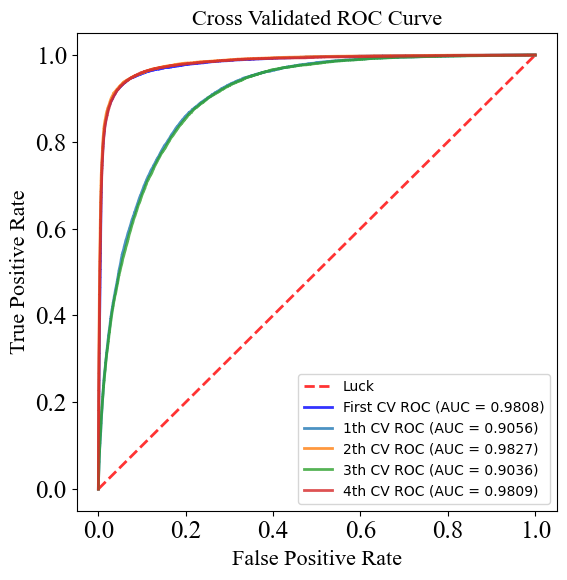

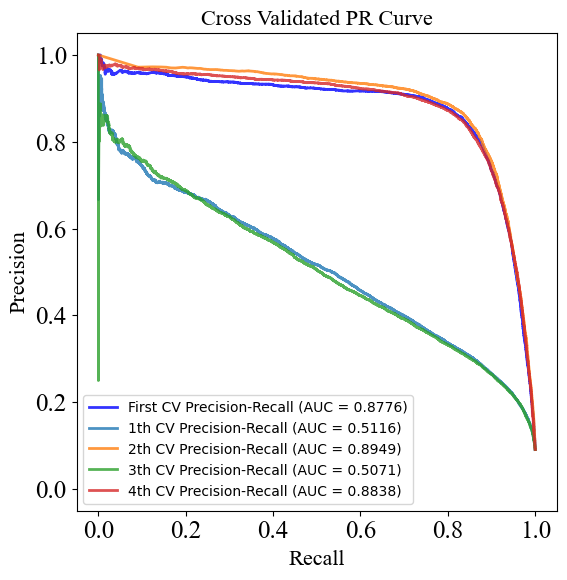

In [21]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

for i, (train, test) in enumerate(kfold.split(train_pep, train_target)):
    training_pep = train_pep[train]
    training_mhc = train_mhc[train]
    training_target = train_target[train]
    
    validation_pep = train_pep[test]
    validation_mhc = train_mhc[test]
    validation_target = train_target[test]

    if i == 0:
        saved_model = create_model(training_pep, training_mhc)
        saved_model.load_weights('model/ACME_testrun/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(validation_pep),np.array(validation_mhc)])
        allprobas_ = np.append(allprobas_, probas_)           
        all_labels = np.append(all_labels, validation_target)
        del saved_model

        fpr, tpr, thresholds = roc_curve(all_labels, allprobas_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(all_labels, allprobas_)
        aupr = average_precision_score(all_labels, allprobas_)
        print(roc_auc)
        print(aupr)

        figure1, ax1 = plt.subplots(figsize=figsize)
        ax1.tick_params(labelsize=18)
        labels = ax1.get_xticklabels() + ax1.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]  
        ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)

        ax1.plot(fpr, tpr, color='b',
                label=r'First CV ROC (AUC = %0.4f)' % (roc_auc),
                    lw=2, alpha=.8)
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_xlabel('False Positive Rate', font1)
        ax1.set_ylabel('True Positive Rate', font1)
        title1 = 'Cross Validated ROC Curve'
        ax1.set_title(title1, font1)
        ax1.legend(loc="lower right")
        
        ########PR_figure
        figure2, ax2 = plt.subplots(figsize=figsize)
        ax2.tick_params(labelsize=18)
        labels = ax2.get_xticklabels() + ax2.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels] 

        ax2.plot(recall, precision, color='b',
                label=r'First CV Precision-Recall (AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)

        ax2.set_xlim([-0.05, 1.05])
        ax2.set_ylim([-0.05, 1.05])
        ax2.set_xlabel('Recall', font1)
        ax2.set_ylabel('Precision', font1)
        title2 = 'Cross Validated PR Curve'
        ax2.set_title(title2, font1)
        ax2.legend(loc="lower left")

    else:
        saved_model = create_model(training_pep, training_mhc)
        saved_model.load_weights('model/ACME_testrun/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(validation_pep),np.array(validation_mhc)])
        allprobas_ = np.append(allprobas_, probas_)           
        all_labels = np.append(all_labels, validation_target)
        del saved_model
        
        fpr, tpr, thresholds = roc_curve(validation_target, probas_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(validation_target, probas_)
        aupr = average_precision_score(validation_target, probas_)
        print(roc_auc)
        print(aupr)

        ax1.plot(fpr, tpr,
        label=str(i)+'th CV ROC (AUC = %0.4f)' % (roc_auc),
            lw=2, alpha=.8)
        ax1.legend(loc="lower right")


        ax2.plot(recall, precision, 
        label=str(i)+'th CV Precision-Recall (AUC = %0.4f)' % (aupr),
        lw=2, alpha=.8)
        ax2.legend(loc="lower left")

    gc.collect()
    tf.keras.backend.clear_session()

In [22]:
figure1.savefig('figures/ACME/5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')
figure2.savefig('figures/ACME/5_fold_prc.jpg', dpi=300, bbox_inches = 'tight')

0.948832999567378


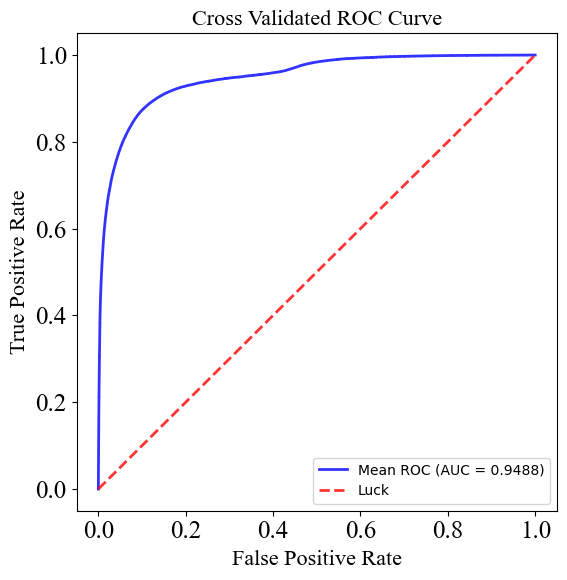

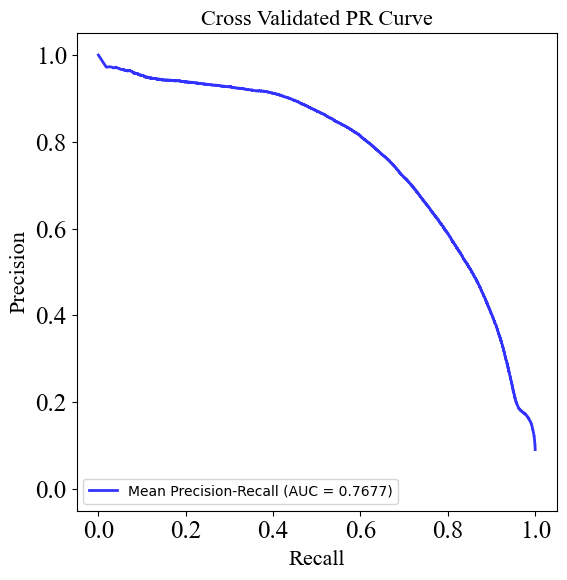

In [23]:
########ROC_figure
figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=18)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  

fpr, tpr, thresholds = roc_curve(all_labels, allprobas_)
roc_auc = auc(fpr, tpr)
print(roc_auc)

ax1.plot(fpr, tpr, color='b',
    label=r'Mean ROC (AUC = %0.4f)' % (roc_auc),
    lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate', font1)
ax1.set_ylabel('True Positive Rate', font1)
title1 = 'Cross Validated ROC Curve'
ax1.set_title(title1, font1)
ax1.legend(loc="lower right")
#figure1.savefig('figures/mean_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')

########PR_figure
figure2, ax2 = plt.subplots(figsize=figsize)
ax2.tick_params(labelsize=18)
labels = ax2.get_xticklabels() + ax2.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

precision, recall, _ = precision_recall_curve(all_labels, allprobas_)
ax2.plot(recall, precision, color='b',
        label=r'Mean Precision-Recall (AUC = %0.4f)' % (average_precision_score(all_labels, allprobas_)),
        lw=2, alpha=.8)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall', font1)
ax2.set_ylabel('Precision', font1)
title2 = 'Cross Validated PR Curve'
ax2.set_title(title2, font1)
ax2.legend(loc="lower left")
#figure2.savefig('figures/mean_5_fold_pr.jpg', dpi=300, bbox_inches = 'tight')


In [24]:
figure1.savefig('figures/ACME/5_fold_mean_roc.jpg', dpi=300, bbox_inches = 'tight')
figure2.savefig('figures/ACME/5_fold_mean_prc.jpg', dpi=300, bbox_inches = 'tight')

In [26]:
allprobas2_=np.array([]) 
all_labels2=np.array([])

0.909630203419962
0.5289602685039535
0.9077901807547031
0.5201245379651485
0.9051416756471817
0.5116112675934295
0.907172001608695
0.5177159158608899
0.908259085013034
0.5219022020669835


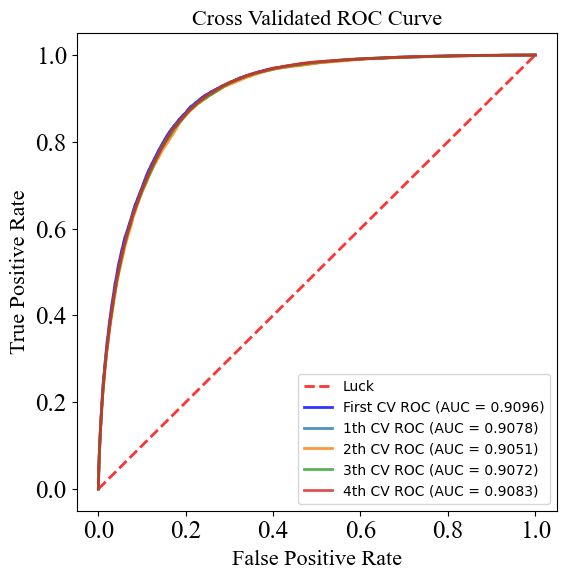

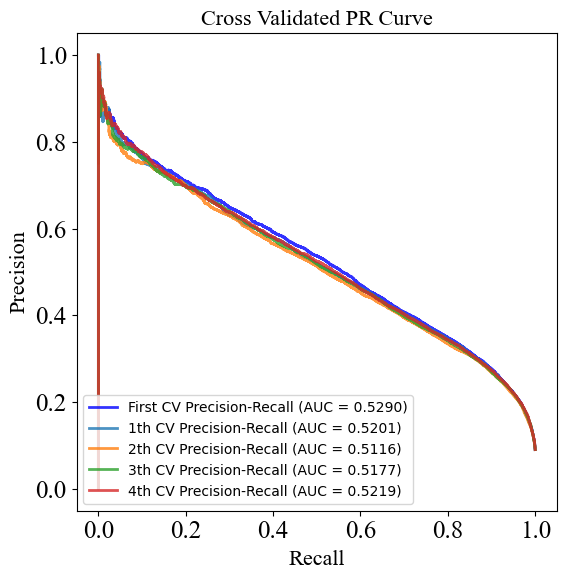

In [27]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

for i in range(5):

    if i == 0:
        saved_model = build_model(training_pep, training_mhc)
        saved_model.load_weights('model/CV/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(test_pep),np.array(test_mhc)])
        allprobas2_ = np.append(allprobas2_, probas_)           
        all_labels2 = np.append(all_labels2, test_target)
        del saved_model

        fpr, tpr, thresholds = roc_curve(all_labels2, allprobas2_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(all_labels2, allprobas2_)
        aupr = average_precision_score(all_labels2, allprobas2_)
        print(roc_auc)
        print(aupr)

        figure1, ax1 = plt.subplots(figsize=figsize)
        ax1.tick_params(labelsize=18)
        labels = ax1.get_xticklabels() + ax1.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels]  
        ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)

        ax1.plot(fpr, tpr, color='b',
                label=r'First CV ROC (AUC = %0.4f)' % (roc_auc),
                    lw=2, alpha=.8)
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_xlabel('False Positive Rate', font1)
        ax1.set_ylabel('True Positive Rate', font1)
        title1 = 'Cross Validated ROC Curve'
        ax1.set_title(title1, font1)
        ax1.legend(loc="lower right")
        
        ########PR_figure
        figure2, ax2 = plt.subplots(figsize=figsize)
        ax2.tick_params(labelsize=18)
        labels = ax2.get_xticklabels() + ax2.get_yticklabels()
        [label.set_fontname('Times New Roman') for label in labels] 

        ax2.plot(recall, precision, color='b',
                label=r'First CV Precision-Recall (AUC = %0.4f)' % aupr,
                lw=2, alpha=.8)

        ax2.set_xlim([-0.05, 1.05])
        ax2.set_ylim([-0.05, 1.05])
        ax2.set_xlabel('Recall', font1)
        ax2.set_ylabel('Precision', font1)
        title2 = 'Cross Validated PR Curve'
        ax2.set_title(title2, font1)
        ax2.legend(loc="lower left")

    else:
        saved_model = build_model(training_pep, training_mhc)
        saved_model.load_weights('model/CV/model_' +str(i)+'.h5')
        probas_ = saved_model.predict([np.array(test_pep),np.array(test_mhc)])
        allprobas2_ = np.append(allprobas2_, probas_)           
        all_labels2 = np.append(all_labels2, test_target)
        del saved_model
        
        fpr, tpr, thresholds = roc_curve(test_target, probas_)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(test_target, probas_)
        aupr = average_precision_score(test_target, probas_)
        print(roc_auc)
        print(aupr)

        ax1.plot(fpr, tpr,
        label=str(i)+'th CV ROC (AUC = %0.4f)' % (roc_auc),
            lw=2, alpha=.8)
        ax1.legend(loc="lower right")


        ax2.plot(recall, precision, 
        label=str(i)+'th CV Precision-Recall (AUC = %0.4f)' % (aupr),
        lw=2, alpha=.8)
        ax2.legend(loc="lower left")
        
    gc.collect()
    tf.keras.backend.clear_session()
figure1.savefig('figures/ACME/test_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')
figure2.savefig('figures/ACME/test_5_fold_prc.jpg', dpi=300, bbox_inches = 'tight')

0.9074038089754369


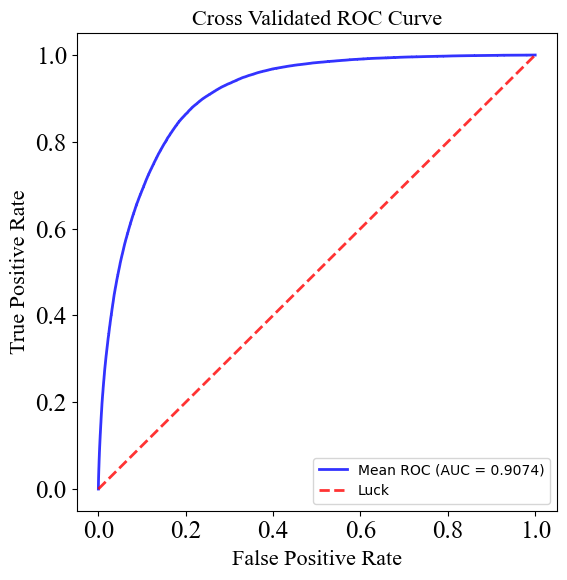

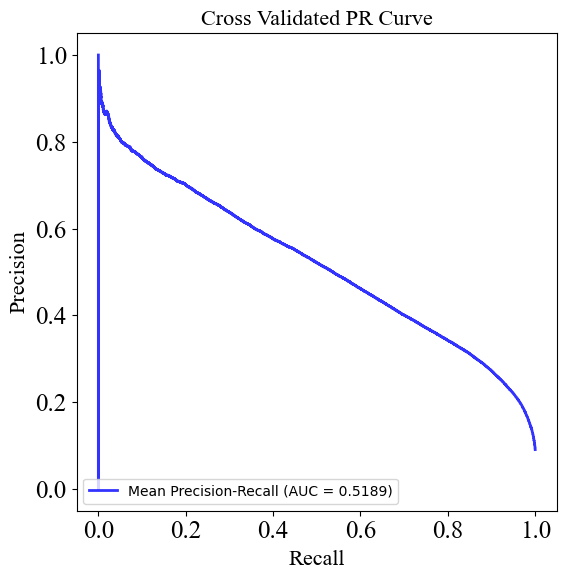

In [28]:
font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}
figsize=6.2, 6.2

########ROC_figure
figure1, ax1 = plt.subplots(figsize=figsize)
ax1.tick_params(labelsize=18)
labels = ax1.get_xticklabels() + ax1.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]  

fpr, tpr, thresholds = roc_curve(all_labels2, allprobas2_)
roc_auc = auc(fpr, tpr)
print(roc_auc)

ax1.plot(fpr, tpr, color='b',
    label=r'Mean ROC (AUC = %0.4f)' % (roc_auc),
    lw=2, alpha=.8)
ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Luck', alpha=.8)
ax1.set_xlim([-0.05, 1.05])
ax1.set_ylim([-0.05, 1.05])
ax1.set_xlabel('False Positive Rate', font1)
ax1.set_ylabel('True Positive Rate', font1)
title1 = 'Cross Validated ROC Curve'
ax1.set_title(title1, font1)
ax1.legend(loc="lower right")
figure1.savefig('figures/ACME/test_mean_5_fold_roc.jpg', dpi=300, bbox_inches = 'tight')

########PR_figure
figure2, ax2 = plt.subplots(figsize=figsize)
ax2.tick_params(labelsize=18)
labels = ax2.get_xticklabels() + ax2.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels] 

precision, recall, _ = precision_recall_curve(all_labels2, allprobas2_)
ax2.plot(recall, precision, color='b',
        label=r'Mean Precision-Recall (AUC = %0.4f)' % (average_precision_score(all_labels2, allprobas2_)),
        lw=2, alpha=.8)

ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.set_xlabel('Recall', font1)
ax2.set_ylabel('Precision', font1)
title2 = 'Cross Validated PR Curve'
ax2.set_title(title2, font1)
ax2.legend(loc="lower left")
figure2.savefig('figures/ACME/test_mean_5_fold_pr.jpg', dpi=300, bbox_inches = 'tight')
